# Learing the Stein discrepancy directly

In [2]:
%load_ext autoreload
from jax import config
config.update("jax_debug_nans", True)
# config.update("jax_disable_jit", True)

import sys
import os
sys.path.append("/home/lauro/code/msc-thesis/svgd/kernel_learning/")
import json_tricks as json
import copy
from functools import partial

from tqdm import tqdm
import jax.numpy as np
from jax import grad, jit, vmap, random, lax, jacfwd, value_and_grad
from jax import lax
from jax.ops import index_update, index
import matplotlib.pyplot as plt
import numpy as onp
import jax
import pandas as pd
import haiku as hk
from jax.experimental import optimizers

import config

import utils
import metrics
import time
import plot
import stein
import kernels
import distributions
import nets
import models

from jax.experimental import optimizers

key = random.PRNGKey(0)

/home/lauro/.virtualenvs/msc-thesis/lib/python3.8/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [3]:
%autoreload

In [4]:
@partial(jit, static_argnums=1)
def compute_sd(samples, fun):
    return stein.stein_discrepancy(samples, target.logpdf, fun)

def get_sds(key, n_samples, fun):
    sds = []
    for subkey in random.split(key, 100):
        samples = proposal.sample(n_samples, key=subkey)
        sds.append(compute_sd(samples, fun))
    return sds

### Parameters

In [34]:
setup = distributions.double_mixture
target, proposal = setup.get()
sizes = [32, 32, 1]
learning_rate = 1e-2
n_steps = 500
lambda_reg = 1/2
batch_size = 1000 # (num samples)
sample_every = False
noise_level = 0.0

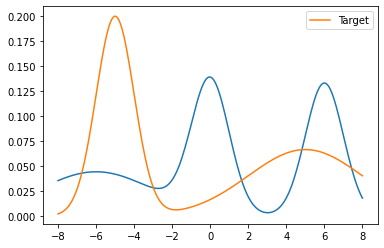

In [35]:
lims = (-8, 8)
plot.plot_fun(proposal.pdf, lims=lims)
plot.plot_fun(target.pdf, label="Target", lims=lims)
plt.legend()

# Train

In [36]:
key, subkey = random.split(key)
learner = models.SDLearner(target=target,
                          key=subkey,
                          sizes=sizes,
                          learning_rate=learning_rate,
                          lambda_reg=lambda_reg)

In [37]:
learner.train_sampling_every_time(proposal=proposal,n_steps=500, batch_size=batch_size, progress_bar=True)

# samples = proposal.sample(batch_size)
# validation_samples = proposal.sample(batch_size)
# _ = learner.train(particles=samples,
#                   validation_particles=validation_samples,
#                   n_steps=n_steps,
#                   noise_level=noise_level,
#                   progress_bar=True)

100%|██████████| 500/500 [00:06<00:00, 77.30it/s] 


In [38]:
samples = proposal.sample(batch_size)
learned_f = utils.negative(learner.get_field(samples))
def optimal_f(x):
    div = 2*learner.lambda_reg
    return grad(lambda x: target.logpdf(x) - proposal.logpdf(x))(x) / div
key, keya, keyb = random.split(key, 3)
sds_optimal = get_sds(keya, batch_size, optimal_f)
sds_learned = get_sds(keyb, batch_size, learned_f)

phistar_rbf_unnorm = stein.get_phistar(kernels.get_rbf_kernel(1), target.logpdf, proposal.sample(batch_size))
phistar_rbf_normed = utils.l2_normalize(phistar_rbf_unnorm, proposal.sample(10_000))
l2_norm_opt = utils.l2_norm_squared(proposal.sample(10_000), optimal_f)
def phistar_rbf(x): return np.sqrt(l2_norm_opt) * phistar_rbf_normed(x)
sds_rbf = get_sds(keya, batch_size, phistar_rbf)

In [39]:
mean, std = stein.get_optimal_sd(key, lambda_reg, target, proposal, batch_size)

Plot results:


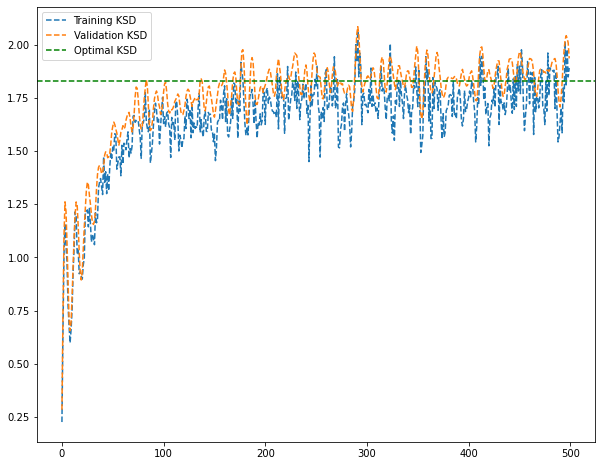

In [40]:
print("Plot results:")

rundata = learner.rundata
fig, ax = plt.subplots(figsize=[10,8])
plt.plot(rundata["training_sd"][:1000], "--", label="Training KSD")
plt.plot(rundata["validation_sd"][:1000], "--", label="Validation KSD")
plt.axhline(y=mean, linestyle="--", label="Optimal KSD", color="green")
plt.legend()

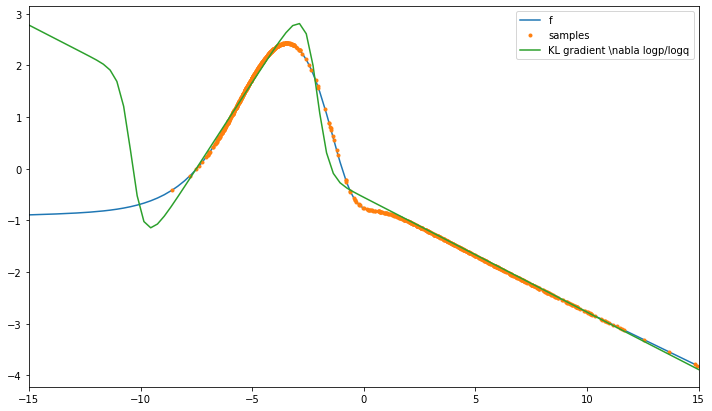

In [20]:
phistar_rbf = stein.get_phistar(kernels.get_rbf_kernel(1), target.logpdf, samples)
def squeezed_f(x):
    x = x.reshape((1,))
    return np.squeeze(learned_f(x))

xlim = (-15, 15)
# plot the stein gradient
scale_rbf=15
grid_n = 100
grid = np.linspace(-15, 15, grid_n)
full_grid = np.concatenate([grid, np.squeeze(samples)]).sort()

fig, ax = plt.subplots(figsize=[12,7])
plt.plot(full_grid, vmap(squeezed_f)(full_grid), label="f")
plt.plot(samples, vmap(squeezed_f)(samples), ".", label="samples")
plt.plot(grid, vmap(optimal_f)(grid), label="KL gradient \\nabla logp/logq")

plt.xlim(xlim)
plt.legend()

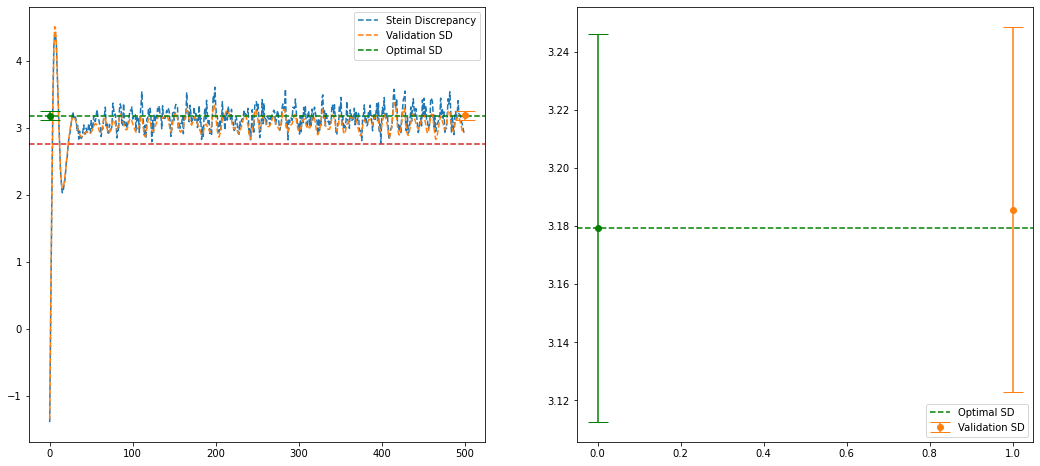

In [21]:
fig, axs = plt.subplots(1, 2, figsize=[18, 8])
axs = axs.flatten()
ylims = (0, 2)
validation_sd = np.array(learner.rundata["validation_sd"])

ax = axs[0]
# training SD
ax.plot(learner.rundata["training_sd"], label="Stein Discrepancy", color="tab:blue", linestyle="--")

# Validation SD
ax.plot(validation_sd, "--", label="Validation SD", color="tab:orange")
ax.errorbar(x=len(learner.rundata["training_sd"]), y=onp.mean(sds_learned), yerr=onp.std(sds_learned), fmt="o", capsize=10, color="tab:orange")

# Optimal SD
ax.axhline(y=onp.mean(sds_optimal), linestyle="--", label="Optimal SD", color="green")
ax.errorbar(x=0, y=onp.mean(sds_optimal), yerr=onp.std(sds_optimal), fmt="o", capsize=10, color="green")
ax.legend()
# ax.set_ylim(ylims)

# KSD
ax.axhline(y=onp.mean(sds_rbf), linestyle="--", label="KSD", color="tab:red")

ax = axs[1]
ax.errorbar(x=1, y=onp.mean(sds_learned), yerr=onp.std(sds_learned), fmt="o", capsize=10, color="tab:orange", label="Validation SD")
ax.errorbar(x=0, y=onp.mean(sds_optimal), yerr=onp.std(sds_optimal), fmt="o", capsize=10, color="green")
ax.axhline(y=onp.mean(sds_optimal), linestyle="--", label="Optimal SD", color="green")
ax.legend()
# ax.set_ylim(ylims)

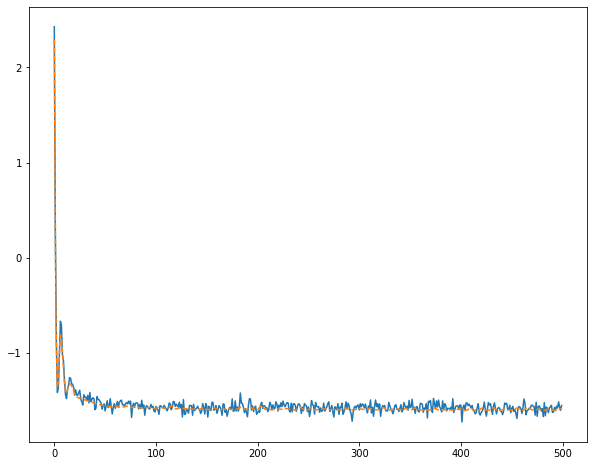

In [22]:
fig, ax = plt.subplots(figsize=[10, 8])
ax.plot(learner.rundata["training_loss"])
validation_loss = np.array(learner.rundata["validation_loss"])
ax.plot(validation_loss, "--")
# ax.set_ylim((-1, 2))

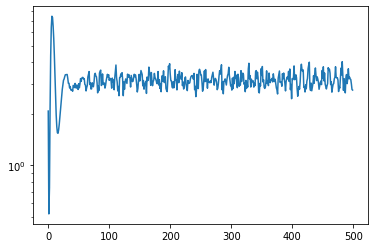

In [23]:
plt.plot(learner.rundata["l2_norm"])
plt.yscale("log")

In [24]:
s = proposal.sample(10_000)
utils.l2_norm(s, squeezed_f)

AttributeError: module 'utils' has no attribute 'l2_norm'

In [ ]:
utils.l2_norm(s, optimal_f)

In [ ]:
fig, ax = plt.subplots(figsize=[12,7])
_ = plt.hist(proposal.sample(1000)[:, 0], alpha=0.5, density=True, bins=50)
_ = plt.xlim(xlim)

In [ ]:
fig, ax = plt.subplots(figsize=[12,7])
plt.plot(full_grid, vmap(grad(squeezed_f))(full_grid), label="grad(f)")
plt.plot(samples, vmap(grad(squeezed_f))(samples), ".", label="samples")
plt.xlim(xlim)
plt.legend()

In [ ]:
plt.plot(learner.rundata["mean_drift"])

In [ ]:
s = proposal.sample(10_000)
sq_norm = utils.l2_norm(s, grad(proposal.logpdf))

NameError: name 'sq_norm' is not defined

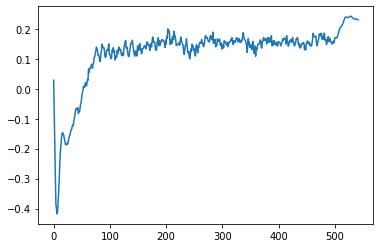

In [14]:
plt.plot(learner.rundata["mean_repulsion"])
plt.axhline(y=sq_norm/4, linestyle="--", label="l2 norm of score function s_q", color="tab:orange")

### compute $f_\theta(x) q(x) \big \vert_{-\infty}^\infty$

In [40]:
def g(x):
    x = np.array(x)
    x = x.reshape((1,1))
    return np.squeeze(learned_f(x) * proposal.pdf(np.squeeze(x)))

print(g(100))
print(g(-100))

sam = proposal.sample(1000)
x_min, x_max = np.min(sam), np.max(sam)

print()
print(f'x min and max: {x_min}, {x_max}')
print(f"g(x_min)={g(x_min)}")
print(f"g(x_max)={g(x_max)}")

print()
print("all of these should be very small (say < 0.1)")

-0.0
-0.0

x min and max: -7.925054550170898, 15.114398002624512
g(x_min)=-0.0005729333497583866
g(x_max)=-0.0009109810343943536

all of these should be very small (say < 0.1)
